**Last week, we learned how to fit a simple model to a single or multiple predictors to predict a given target variable. However, by fixing the number of predictors and by fixing the model's hyper-parameters beforehand, we restricted ourselves to a single model. By doing so, we omitted to explore a broader range of models, one of which might better explain to relationship between our input and target variables.**

**In this lab, we'll experiment with the general methodology of model selection, meaning that we'll define a set of predifined models, and we'll retain the one that minimizes the out-of-sample error.**

**First, import the necessary libraries**

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_validate, LeaveOneOut, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SequentialFeatureSelector

**1) In this lab, we will be working with the 'fish_lab.csv' dataset, which contains several characteristics about fish, such as their weights, lengths, and species, amongst others. Load the dataset as a pandas dataframe, inspect its properties and check for any missing values. Change the data type of 'Species' to 'category'.**

In [ ]:
file = './fish_lab.csv'
df = pd.read_csv(file, index_col=0)
df = df.astype({'Species' : 'category'})
print(df.info())
print(df.head())
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Species  154 non-null    category
 1   Weight   151 non-null    float64 
 2   Length1  152 non-null    float64 
 3   Length2  147 non-null    float64 
 4   Length3  156 non-null    float64 
 5   Height   159 non-null    float64 
 6   Width    154 non-null    float64 
dtypes: category(1), float64(6)
memory usage: 9.2 KB
None
  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3   Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4   Bream   430.0     26.5     29.0     34.0  12.4440  5.1340
Species     5
Weight      8
Length1     7
Length2    12
Length3     3
Height      0
Width       5
dtype: int64


**2) Does the dataframe contain any missing values ? If yes, replace the missing values by the sample mean for continuous variables. For missing categorical variables, replace them by the most frequent occurence of the corresponding column. Check the 'SimpleImputer()' class of the scikit-learn library.**

In [ ]:
imp_cont = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

cat_columns = df.select_dtypes(include=['category']).columns
cont_columns = df.select_dtypes(exclude=['category']).columns

df[cat_columns] = imp_cat.fit_transform(df[cat_columns])
df[cont_columns] = imp_cont.fit_transform(df[cont_columns])

print(df.isna().sum())

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64


**3) Unfortunately, categorical variables cannot be fed directly to the model. One approach to deal with the problem is to create 'dummy variables' out of the categorical one, where each dummy variable takes the value '1' if the observation belongs to that class, and '0' otherwise. Check the method 'get_dummies' of the pandas library to generate such dummy variables.** 

In [ ]:
df_species = pd.get_dummies(df.iloc[:, 0])
df.drop('Species', inplace=True, axis=1)
df = pd.concat([df_species, df], axis=1)
print(df.columns)

Index(['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish',
       'Weight', 'Length1', 'Length2', 'Length3', 'Height', 'Width'],
      dtype='object')


**4) Now let's make some predictions. Select the variable 'Weight' as predictor and 'Height' as the target variable. Generate a scatter plot of the two variables, and fit a simple linear regression model to the data. Split your datasets into a training and test set following a 60/40 partition. Evaluate the model on the Mean Squared Error and on the coefficent of determination. Report such metrics for both the training and test sets.**

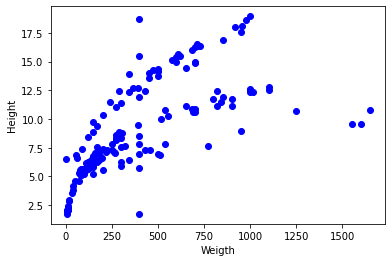

Training MSE : 9.155062192264335
Test MSE : 10.202066214789005
Training R2 : 0.4726690974697493
Test R2 : 0.47852813750422196


In [ ]:
X = df.Weight.values[:, np.newaxis]
y = df.Height.values
model = LinearRegression(fit_intercept=True)

fig, ax = plt.subplots()
ax.scatter(X.ravel(), y, color='blue')
ax.set_xlabel('Weigth')
ax.set_ylabel('Height')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, test_size=0.4, shuffle=True)

model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print('Training MSE : {}'.format(mse_train))
print('Test MSE : {}'.format(mse_test))
print('Training R2 : {}'.format(r2_train))
print('Test R2 : {}'.format(r2_test))

**5) By doing a 60/40 partition for our training and test sets, we are unfortunately neglecting a significant portion of data that could come in handy for training our model. This is where cross-validation becomes highly useful, as it allows us to train on a greater proportion of the total dataset.**

**Use cross-validation to train the model. Check the performance of the model for both a 10 folds cross-validation, and a leave-one-out cross-validation. In both cases, evaluate the models on the MSE. Report the mean and the variance of the test MSE across each folds. What do you observe ? Check the classes 'cross_validate()' and 'LeaveOneOut() of the scikit-learn library.**

In [ ]:
cv_results = cross_validate(model, X, y, cv=10, scoring=['neg_mean_squared_error'])

test_mse = -cv_results['test_neg_mean_squared_error']

mean_test_mse = test_mse.mean()
var_test_mse = np.var(test_mse)

print('10 folds CV mean test MSE : {}'.format(mean_test_mse))
print('10 folds CV variance of test MSE : {}'.format(var_test_mse))

10 folds CV mean test MSE : 13.161285086064387
10 folds CV variance of test MSE : 156.40891319174224


In [ ]:
cv_results = cross_validate(model, X, y, cv=LeaveOneOut(), scoring=['neg_mean_squared_error'])

test_mse = -cv_results['test_neg_mean_squared_error']

mean_test_mse = test_mse.mean()
var_test_mse = np.var(test_mse)

print('LeaveOneOut CV mean test MSE : {}'.format(mean_test_mse))
print('LeaveOneOut CV variance of test MSE : {}'.format(var_test_mse))

LeaveOneOut CV mean test MSE : 10.417109910203429
LeaveOneOut CV variance of test MSE : 353.2777934545741


**6) Maybe a linear model is not the best option to model the relationship between the variables 'Weight' and 'Height'. Instead of fitting a linear model, let's fit a polynomial model of specified degree. First, transform the 'Weight' feature to quadratic, and fit a simple linear regression model to predict the variable 'Height' using a 10 folds cross-validation, and evaluate on the MSE. Report the mean test MSE across each folds. Check the method PolynomialFeatures() to transform the input variable.**


In [ ]:
transfo = PolynomialFeatures(degree=2)
X2 = transfo.fit_transform(X)
cv_results = cross_validate(model, X2, y, cv=10, scoring=['neg_mean_squared_error'])

test_mse = -cv_results['test_neg_mean_squared_error'].mean()

print('Test MSE for a polynomial model of degree 2 : {}'.format(test_mse))

Test MSE for a polynomial model of degree 2 : 7.897678987867602


**7) Let's now see how the MSE vary if we increase the model's complexity. For polynomial degrees between 1 and 20, repeatedly fit the model using a simple linear regression model and cross-validation, and plot the evolution of the mean train and test MSE in function of the polynomial degree. What do you observe ? Use the function 'PolynomialRegression' as the 'model' argument of the class 'cross_validate', and make sure to understand what the 'make_pipeline' method does.**

**Moreover, can you identify which degree would be the best choice to model the relationship between the variables 'Weigth' and 'Height' ?**

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

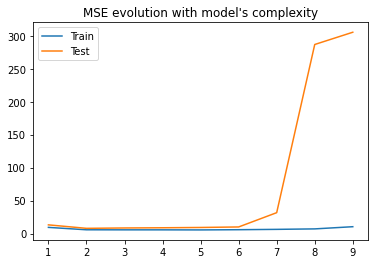

In [ ]:
mse_train_list, mse_test_list = [], []
degrees = [i for i in range(1,10)]
for degree in degrees:
    model = PolynomialRegression(degree, fit_intercept=True)
    cv_results = cross_validate(model, X, y, cv=10, scoring=['neg_mean_squared_error'], return_train_score=True)
    train_mse = -cv_results['train_neg_mean_squared_error'].mean()
    test_mse = -cv_results['test_neg_mean_squared_error'].mean()
    mse_train_list.append(train_mse)
    mse_test_list.append(test_mse)

fig, ax = plt.subplots()
ax.plot(degrees, mse_train_list, label='Train')
ax.plot(degrees, mse_test_list, label='Test')
ax.set_title('MSE evolution with model\'s complexity')
ax.legend()
plt.show()

**8) Maybe selecting more than one feature might also result in a better fit. Use a forward selection strategy to select to best subset of 3 predictors for predicting the target variable 'Height'. See the class 'SequentialFeaturesSelector()' of the scikit-learn library. Use the MSE as a scoring function.**

**Report the selected variables, and fit a multiple linear regression model to predict the variable 'Height' using the selected predictors with a 10 folds cross-validation. Report the mean MSE across each folds.** 

**9) Usually, models have more than one hyper-parameter that can be tuned in order to find the model that best captures the relationship between our input and target variables. For instance, in the case of a simple linear regression using a polynomial transformation on the input variables, the hyper-parameter space would be the polymial's degree, and whether or not to fit the intercept. Inspecting each combination of hyper-parameters and selecting the combination that results in the best model is called Grid Search. However, manually inspecting each combination could be a very tedious task, but fortunatly, scikit-learn provides a class GridSearchCV() that implements this protocol for you.**

**Select 'Weight' as predictor and 'Height' as target variable, and perform a Grid Search on the hyper-parameters space of a simple linear regression using a polynomial transformation of input variable. Search for degrees varying between 1 and 20, and whether or not the intercept should be fit. Report the best subset of hyper-parameters, as well as the test MSE for a model fitted using this subset. Plot the obtained regression curve**